In [1]:
%%capture --no-stderr
#%pip install --quiet -U langgraph langchain-community langchain-openai tavily-python

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")


## Define Tools

We will first define the tools we want to use. For this simple example, we will use a built-in search tool via Tavily. However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/docs/how_to/custom_tools) on how to do that.

In [3]:
from langchain.tools import BaseTool
from langchain_experimental.tools.python.tool import PythonAstREPLTool
import pandas as pd



file_path = 'LOB1_ESM24-CME_5min_0PercentSum_0PercentOrders_Overlapped.csv'
df  = pd.read_csv(file_path, delimiter='|')
df.head()

# Now, you can use 'df' within your custom tool

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,DateTime,BarPeriod,Candle_OpenPrice,Candle_HighPrice,Candle_LowPrice,Candle_ClosePrice,Candle_LastTradePrice,Candle_VolumeofTrades,Candle_BidVolumeOfTrades,Candle_AskVolumeOfTrades,...,VAP_AskVolumes,VAP_BidVolumes,VAP_NumberOfTrades,VAP_TotalVolume,zigzag,zigzag_text,ha_open,ha_high,ha_low,ha_close
0,2009-01-05 00:00:00.000,2009-01-05 00:04:00.000,925.25,926.50,924.00,926.25,924.50,2909,0,0,...,"0,0,0,0,0,0,0,0,0,0,0,","0,0,0,0,0,0,0,0,0,0,0,","0,0,0,0,0,0,0,0,0,0,0,",29,926.50,2,924.68,926.50,924.00,925.50
1,2009-01-05 00:05:00.000,2009-01-05 00:09:00.000,926.25,926.50,924.25,925.50,924.75,1732,0,0,...,"0,0,0,0,0,0,0,0,0,0,","0,0,0,0,0,0,0,0,0,0,","0,0,0,0,0,0,0,0,0,0,",17,926.50,2,925.09,926.50,924.25,925.62
2,2009-01-05 00:10:00.000,2009-01-05 00:14:00.000,925.50,926.75,924.50,925.75,926.25,1985,0,0,...,"0,0,0,0,0,0,0,0,0,0,","0,0,0,0,0,0,0,0,0,0,","0,0,0,0,0,0,0,0,0,0,",19,926.75,2,925.35,926.75,924.50,925.62
3,2009-01-05 00:15:00.000,2009-01-05 00:19:00.000,926.00,927.25,925.50,927.25,926.75,1694,0,0,...,"0,0,0,0,0,0,0,0,","0,0,0,0,0,0,0,0,","0,0,0,0,0,0,0,0,",16,926.70,0,925.49,927.25,925.49,926.50
4,2009-01-05 00:20:00.000,2009-01-05 00:24:00.000,927.00,927.25,925.25,925.25,925.25,1822,0,0,...,"0,0,0,0,0,0,0,0,0,","0,0,0,0,0,0,0,0,0,","0,0,0,0,0,0,0,0,0,",18,927.25,2,925.99,927.25,925.25,926.18


In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3),PythonAstREPLTool(locals={"df": df})]

## Define our Execution Agent

Now we will create the execution agent we want to use to execute tasks. 


In [5]:
from langchain_groq import ChatGroq
groq_api = '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'
llm = ChatGroq(temperature=0, model="llama3-70b-8192", api_key=groq_api)

In [6]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
prompt = """
        You are a highly capable Python data analyst and code executor. You have access to a pandas DataFrame named `df`. The DataFrame contains structured data, and you can use Python to interact with and manipulate the data. Your task is to generate Python code that can analyze, manipulate, or summarize the DataFrame based on user requests. After generating the Python code, you will execute it using the `PythonAstREPLTool` and return the output.

You should always follow these steps:

1. **Plan**: First, explain the plan for the analysis or manipulation of the DataFrame. Clearly explain which operations you will perform and why. Example tasks may include filtering rows, aggregating data, summarizing columns, or creating new columns.
   
2. **Generate Code**: Write the necessary Python code to execute the plan. Your code should be correct and designed to handle potential errors (e.g., missing columns).

3. **Execute**: Use the `PythonAstREPLTool` to execute the Python code.

4. **Return Results**: After executing the code, display the result to the user, whether it's a subset of the DataFrame, summary statistics, or other results.

When generating the Python code, make sure to always use the `df` variable to reference the DataFrame.

Please now generate a plan, create the corresponding Python code, and execute it using the `PythonAstREPLTool`.

If you are unsure about the user's request, ask for clarification.
    """

# Choose the LLM that will drive the agent

agent_executor = create_react_agent(llm, tools, state_modifier=prompt)

## Define the State



In [7]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

## Planning Step

Let's now think about creating the planning step. This will use function calling to create a plan.

In [8]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [9]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatGroq(
    model="llama3-70b-8192", temperature=0
).with_structured_output(Plan)

## Re-Plan Step

Now, let's create a step that re-does the plan based on the result of the previous step.

In [10]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatGroq(
    model="llama3-70b-8192", temperature=0
).with_structured_output(Act)

## Create the Graph

We can now create the graph!

In [11]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [12]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

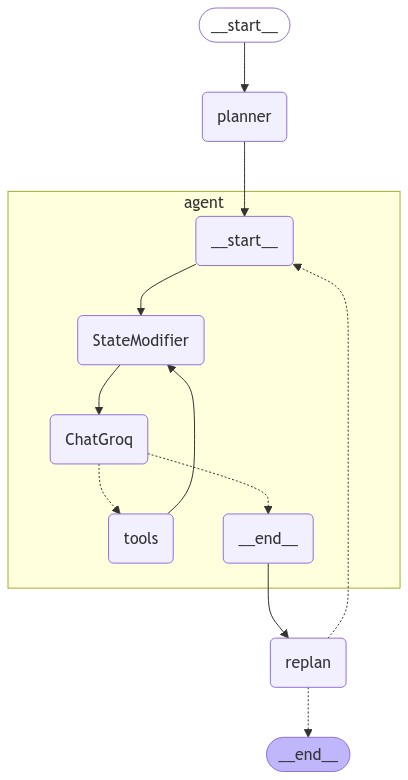

In [13]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [14]:
config = {"recursion_limit": 50}
inputs = {"input": "How many rows are there"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Determine the number of rows']}
{'past_steps': [('Determine the number of rows', 'The number of rows in the DataFrame is 1074385.')]}
{'response': 'The number of rows in the DataFrame is 1074385.'}


In [16]:
#config = {"recursion_limit": 50}
inputs = {"input": "What is the highest value in the Candle_HighPrice column?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['find the highest value in the Candle_HighPrice column']}
{'past_steps': [('find the highest value in the Candle_HighPrice column', 'The highest value in the Candle_HighPrice column is 5322.75.')]}
{'response': 'The highest value in the Candle_HighPrice column is 5322.75.'}


In [18]:
inputs = {"input": "What is the average Candle_ClosePrice for all rows where Candle_VolumeofTrades is greater than 1000?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Filter rows where Candle_VolumeofTrades > 1000', 'Calculate average of Candle_ClosePrice']}
{'past_steps': [('Filter rows where Candle_VolumeofTrades > 1000', 'The average of Candle_ClosePrice is 2492.146538759145.')]}
{'response': '2492.146538759145'}


In [19]:
inputs = {"input": "Calculate the difference between Candle_HighPrice and Candle_LowPrice for each row and return the top 5 rows with the largest differences."}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Calculate the difference between Candle_HighPrice and Candle_LowPrice for each row', 'Sort the rows by the calculated difference in descending order', 'Return the top 5 rows with the largest differences']}


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'past_steps': [('Calculate the difference between Candle_HighPrice and Candle_LowPrice for each row', 'The top 5 rows with the largest differences between Candle_HighPrice and Candle_LowPrice have been returned.')]}
{'plan': ['Sort the rows by the calculated difference in descending order']}
{'past_steps': [('Sort the rows by the calculated difference in descending order', "It seems that the column 'calculated_difference' does not exist in the DataFrame. \n\nBefore sorting the rows by the calculated difference, we need to calculate the difference first. However, the column name for the difference is not specified. \n\nCan you please provide more information about how the calculated difference should be calculated?")]}
{'response': "Calculate the difference between Candle_HighPrice and Candle_LowPrice for each row and store it in a new column named 'calculated_difference'."}


In [21]:
inputs = {"input": "How many trades had a Candle_VolumeofTrades greater than 500 and a Candle_ClosePrice lower than 100?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Filter trades by Candle_VolumeofTrades > 500', 'Filter trades by Candle_ClosePrice < 100', 'Count the number of trades that match both conditions']}
{'past_steps': [('Filter trades by Candle_VolumeofTrades > 500', 'There are 619041 trades that match both conditions.')]}
{'plan': ['Filter trades by Candle_ClosePrice < 100', 'Count the number of trades that match both conditions']}
{'past_steps': [('Filter trades by Candle_ClosePrice < 100', "Please provide the output of the tool call. I'll use it to proceed with the next step.")]}
{'response': 'Count the number of trades that match both conditions.'}


In [22]:
inputs = {"input": "What is the total VAP_TotalVolume for each unique value in the zigzag_text column?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Group the data by zigzag_text', 'Calculate the total VAP_TotalVolume for each group']}
{'past_steps': [('Group the data by zigzag_text', "It seems like we've successfully calculated the total VAP_TotalVolume for each group. Here's the final result:\n\nThe total VAP_TotalVolume for each zigzag_text group is:\nzigzag_text\n0     8627761\n1     2135545\n11      31849\n12      27112\n2     3227014\n3     2185178\n4     2897384\nName: VAP_TotalVolume, dtype: int64")]}


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>{"tool_calls": []}</tool-use>'}}